# CluStream

官方文档：[CluStream](https://riverml.xyz/latest/api/cluster/CluStream/)

## 1. CluStream 算法介绍

CluStream（Clustering Stream）算法是一种用于数据流聚类的算法，主要应用于大规模、高速生成的数据流场景。它能够高效地对数据流进行实时聚类，且支持动态变化的聚类结构。值得注意的是，CluStream 在执行聚类时需要明确指定聚类数，这包括微观聚类阶段的微簇数量和宏观聚类阶段的最终簇数量。

### CluStream算法的基本流程

CluStream算法的基本思想是通过以下两个主要步骤来对数据流进行聚类：

1. **微观聚类（Micro-Clustering）**：
   - CluStream 将数据流分为多个小的时间窗口（或者称为微观窗口），每个窗口中的数据被聚成一个微观聚类。微观聚类通常是通过高效的聚类算法（如 k-means）进行实时更新的。
   - 每个微观聚类代表了一段时间内流数据的局部模式。这些微观聚类能够捕捉到数据流的变化，确保聚类反映数据流的动态特征。

2. **宏观聚类（Macro-Clustering）**：
   - 宏观聚类对微观聚类进行再聚类。微观聚类本身不直接用于最终的聚类结果，而是通过宏观聚类将这些微观聚类进行合并，形成一个全局聚类的结构。
   - 宏观聚类算法通常基于相似度度量（如欧几里得距离或余弦相似度）对微观聚类进行进一步聚类。这一层聚类有助于捕捉整个数据流的全局模式。

### CluStream算法的优势：

- **处理数据流**：CluStream 能够处理数据流，适应数据的增量输入，实时更新聚类结果。
- **动态性**：随着数据流的变化，CluStream 能够动态调整聚类结构，适应数据的变化。
- **高效性**：它将计算复杂度分散到微观聚类和宏观聚类的层次，能够高效地处理大规模数据流。

### 应用场景：

- **实时数据流分析**：如传感器数据、金融市场数据、社交网络流数据等。
- **在线聚类**：适用于需要实时处理大量数据并更新聚类结果的场景。

总体而言，CluStream 是一种能够高效处理动态数据流并适应实时聚类需求的算法，尤其适合那些数据量巨大且数据分布不断变化的应用场景。

（以上内容来自 ChatGPT 4o，略有修改）

In [1]:
import time
import numpy as np
import utils

from sklearn.datasets import make_blobs
from river import cluster, stream

##  2. CluStream 的简单示例

In [2]:
cluster_num = 8
X, _ = make_blobs(n_samples=500, centers=cluster_num, cluster_std=0.60, random_state=0)

# 打乱数据
np.random.shuffle(X)

# 初始化 CluStream 模型
clustream = cluster.CluStream(n_macro_clusters=3,  # n_macro_clusters 是最终形成的宏簇（macro-clusters）的数量
                              max_micro_clusters=100,  # max_micro_clusters 是微簇（micro-clusters）的最大数量
                              micro_cluster_r_factor=2,  # micro_cluster_r_factor 是微簇半径的乘数因子
                              time_window=1000,  # time_window 是时间窗口的大小
                              time_gap=5)  # time_gap 是增量 K-Means 算法应用的时间间隔

# 对数据流进行增量学习
for i, (x, _) in enumerate(stream.iter_array(X)):
    clustream.learn_one(x)

# 预测新数据点的聚类
clustream.predict_one({0: -1, 1: -2})

0

In [3]:
# 输出聚类中心
clustream.centers

{0: defaultdict(functools.partial(<bound method Random.gauss of <random.Random object at 0x7fe98ebf3210>>, 0, 1),
             {0: 3.4437597789759478, 1: 0.7703697393642401}),
 1: defaultdict(functools.partial(<bound method Random.gauss of <random.Random object at 0x7fe98ebf3210>>, 0, 1),
             {0: -8.259209443110588, 1: -8.295033736217082}),
 2: defaultdict(functools.partial(<bound method Random.gauss of <random.Random object at 0x7fe98ebf3210>>, 0, 1),
             {0: 1.2270162550826313, 1: 7.032351084700985})}

## 3. CluStream 的可选参数

参数说明：

| 参数                    | 默认值 | 说明                                          |
|------------------------|-------|----------------------------------------------|
| n_macro_clusters       | 5     | k-means 算法中的聚类数量。                 |
| max_micro_clusters     | 100   | 使用的最大微簇数量。     |
| micro_cluster_r_factor | 2     | 微簇半径的乘数因子。在决定将新数据点添加到微簇时，最大边界定义为微簇中数据点从质心的均方根 (RMS) 偏差的 micro_cluster_r_factor 倍。 |
| time_window            | 1000  | 如果当前时间是 T，时间窗口是 h，我们只考虑在 (T-h,T) 期间到达的数据。 |
| time_gap               | 100   | 在每个 time_gap 之后，对当前可用的微簇应用增量 k-means 聚类算法，以形成最终的宏聚类解决方案。 |
| seed                   | None  | 用于生成初始质心位置的随机种子。            |
| kwargs                 |       | 传递给增量 kmeans 的 cluster.KMeans 的其他参数。    |

## 4. CluStream 全量训练

使用 CluStream 对全量数据训练后进行预测。

### 1）宏簇数量 与 真实聚类数 相等的情况

当宏簇数量`n_macro_clusters` 数量与当前聚类数相同时：

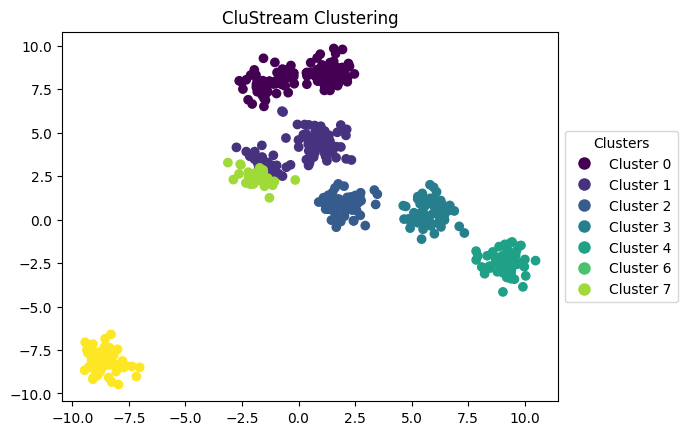

In [4]:
n_macro_clusters = cluster_num

# 初始化 CluStream 模型
clustream = cluster.CluStream(n_macro_clusters=n_macro_clusters,
                              max_micro_clusters=100,
                              micro_cluster_r_factor=2,
                              time_window=1000,
                              time_gap=5)

# 对数据流进行增量学习
for i, (x, _) in enumerate(stream.iter_array(X)):
    clustream.learn_one(x)

# 对全量数据做预测
clustream_labels = list()
for x, _ in stream.iter_array(X):
    prediction = clustream.predict_one(x)
    clustream_labels.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=clustream_labels,
                     title='CluStream Clustering')

### 2）宏簇数量 与 真实聚类数 不等的情况

当宏簇数量`n_macro_clusters` 数量与当前聚类数不匹配时：

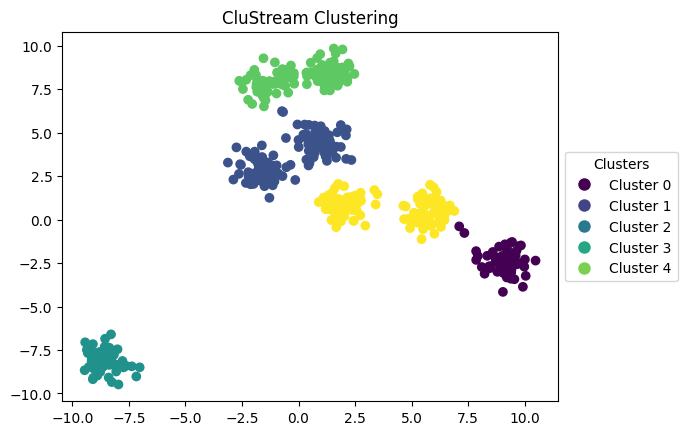

In [5]:
n_macro_clusters = 5
assert n_macro_clusters != cluster_num

# 初始化 CluStream 模型
clustream = cluster.CluStream(n_macro_clusters=n_macro_clusters,
                              max_micro_clusters=100,
                              micro_cluster_r_factor=2,
                              time_window=1000,
                              time_gap=5)

# 对数据流进行增量学习
for i, (x, _) in enumerate(stream.iter_array(X)):
    clustream.learn_one(x)

# 对全量数据做预测
clustream_labels = list()
for x, _ in stream.iter_array(X):
    prediction = clustream.predict_one(x)
    clustream_labels.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=clustream_labels,
                     title='CluStream Clustering')

## 5. DenStream 与 CluStream 增量训练效果对比

收集在学习过程中产生的聚类标签，对比效果。

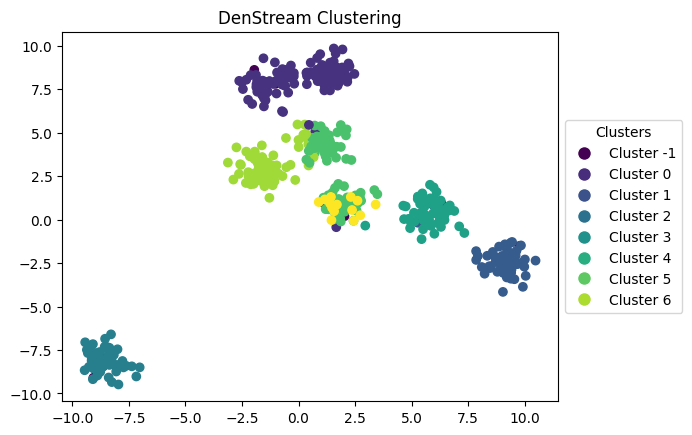

In [6]:
# DenStream 增量训练

# 初始化 DenStream 聚类器
denstream = cluster.DenStream(decaying_factor=0.01,
                              beta=0.75,
                              mu=2,
                              epsilon=0.9,
                              n_samples_init=10)

# 对数据流进行增量学习
denstream_inc_lables = []
for x, _ in stream.iter_array(X):
    denstream.learn_one(x)
    prediction = denstream.predict_one(x)
    denstream_inc_lables.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=denstream_inc_lables,
                     title='DenStream Clustering')

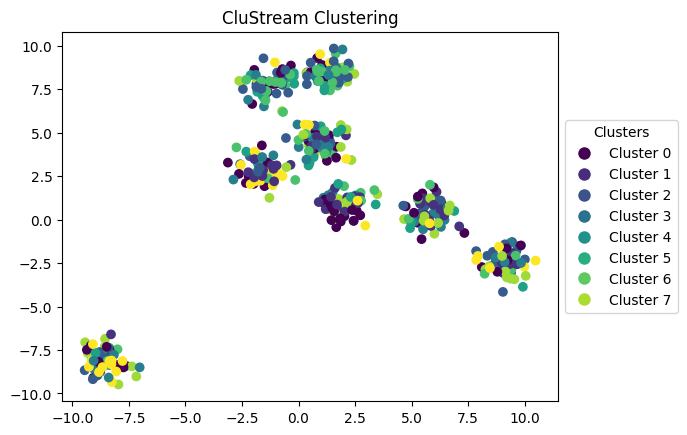

In [7]:
# CluStream 增量训练

# 初始化 CluStream 模型
clustream = cluster.CluStream(n_macro_clusters=cluster_num,
                              max_micro_clusters=10,
                              micro_cluster_r_factor=2,
                              time_window=1000,
                              time_gap=3)

# 对数据流进行增量学习
clustream_inc_lables = []
for i, (x, _) in enumerate(stream.iter_array(X)):
    # 增加等待时间
    if i % 30 == 0:
        time.sleep(1)

    clustream.learn_one(x)
    prediction = clustream.predict_one(x)
    clustream_inc_lables.append(prediction)

# 绘图
utils.simple_scatter(data=X,
                     labels=clustream_inc_lables,
                     title='CluStream Clustering')

结论：如果你需要对数据做增量学习，并且实时使用聚类标签，那么 DenStream 的效果更胜一筹。